# Reorganized verion of the Visualize and Save prediction

In [ ]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Image.MAX_IMAGE_PIXELS = 933120000 # Increase the allowed image size limit for PIL

# Constants
COVINGTON_REF_PATH = "/content/drive/MyDrive/Meta_learning_research/Notebooks/TIFF/Covington/new_ref_w_nodata.tif"
ROWANCREEK_REF_PATH = "/content/drive/MyDrive/Meta_learning_research/Notebooks/TIFF/RowanCounty/reference_26102019.tif"
PATCH_SIZE = 224
OVERLAP = 30

def load_and_reconstruct_patches(patches_path, location):
    """Loads patches and reconstructs the image based on the specified location."""
    patches = np.load(patches_path)

    if location == "rowancreek":
        num_rows = get_num_rows(location, ROWANCREEK_REF_PATH, PATCH_SIZE, OVERLAP)
        return reconstruct_image_from_patches(patches, ROWANCREEK_REF_PATH, num_rows)
    elif location == "covinton":
        return reconstruct_image_from_patches(patches, COVINGTON_REF_PATH, 41)
    else:
        raise ValueError("Invalid location. Supported locations: 'rowancreek', 'covinton'")

def reconstruct_image_from_patches(patches, reference_file_path, num_rows):
    """Reconstructs the image from patches and saves it as a TIFF file."""
    output_size, patch_size, overlap = get_reconstruction_parameters(reference_file_path)
    reconstructed_image = reconstruct_image(patches, output_size, patch_size, overlap, num_rows)
    # save_and_display_image(reconstructed_image)
    return reconstructed_image

def get_reconstruction_parameters(reference_file_path):
    """Gets image dimensions, patch size and overlap from the reference image."""
    width, height = get_image_dimensions(reference_file_path)
    output_size = (width, int(height / 2))
    return output_size, PATCH_SIZE, OVERLAP

def get_num_rows(location, ref_file_path, patch_size, overlap):
    """Calculates the number of rows based on location and patch parameters."""
    if location == "covington":
        return 41  # Fixed number of rows for Covington
    else:  # Assuming 'else' refers to Rowancreek
        width, height = get_image_dimensions(ref_file_path)
        effective_patch_size = patch_size - overlap * 2
        num_rows = (height - overlap) // effective_patch_size + 1
        return num_rows

def reconstruct_image(patches, out_dims, patch_size, overlap, num_rows):
    """Reconstructs the image from patches with optimized handling of overlaps."""
    width, height = out_dims
    stride = patch_size - overlap * 2

    reconstructed = np.zeros((height, width), dtype=np.float32)
    count_matrix = np.zeros((height, width), dtype=np.int32)

    for y in range(num_rows):
        for x in range(width // stride + 1):
            patch_idx = y * (width // stride) + x
            if patch_idx >= patches.shape[0]:
                break

            end_x = min(x * stride + patch_size, width)
            end_y = min(y * stride + patch_size, height)

            reconstructed[y * stride:end_y, x * stride:end_x] += patches[patch_idx][:end_y - y * stride, :end_x - x * stride].squeeze()
            count_matrix[y * stride:end_y, x * stride:end_x] += 1

    reconstructed /= count_matrix  # Avoid division by zero

    return reconstructed

def get_image_dimensions(file_path):
    """Opens an image and returns width and height."""
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def save_and_display_image(image_array, npy_path, display_only=False):
    """Saves the image as a TIFF in the same location as the npy file (optionally)
       and displays it.

    Args:
        image_array (numpy.ndarray): The image array to display and potentially save.
        npy_path (str): The path to the original NPY file.
        display_only (bool): If True, only display the image, otherwise save and display.
                             Defaults to False.
    """

    # Display the image using matplotlib
    plt.figure(figsize=(40, 40))  # Adjust figure size as needed
    plt.imshow(image_array * 255, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

    # Conditional saving
    if not display_only:
        filename, _ = os.path.splitext(npy_path)
        output_path = filename + '.tif'

        # Convert the numpy array to an image for saving (assuming grayscale)
        img = Image.fromarray(np.uint8(image_array))
        img.save(output_path)


<ipython-input-18-9640f73c71b9>:70: RuntimeWarning: invalid value encountered in divide
  reconstructed /= count_matrix  # Avoid division by zero


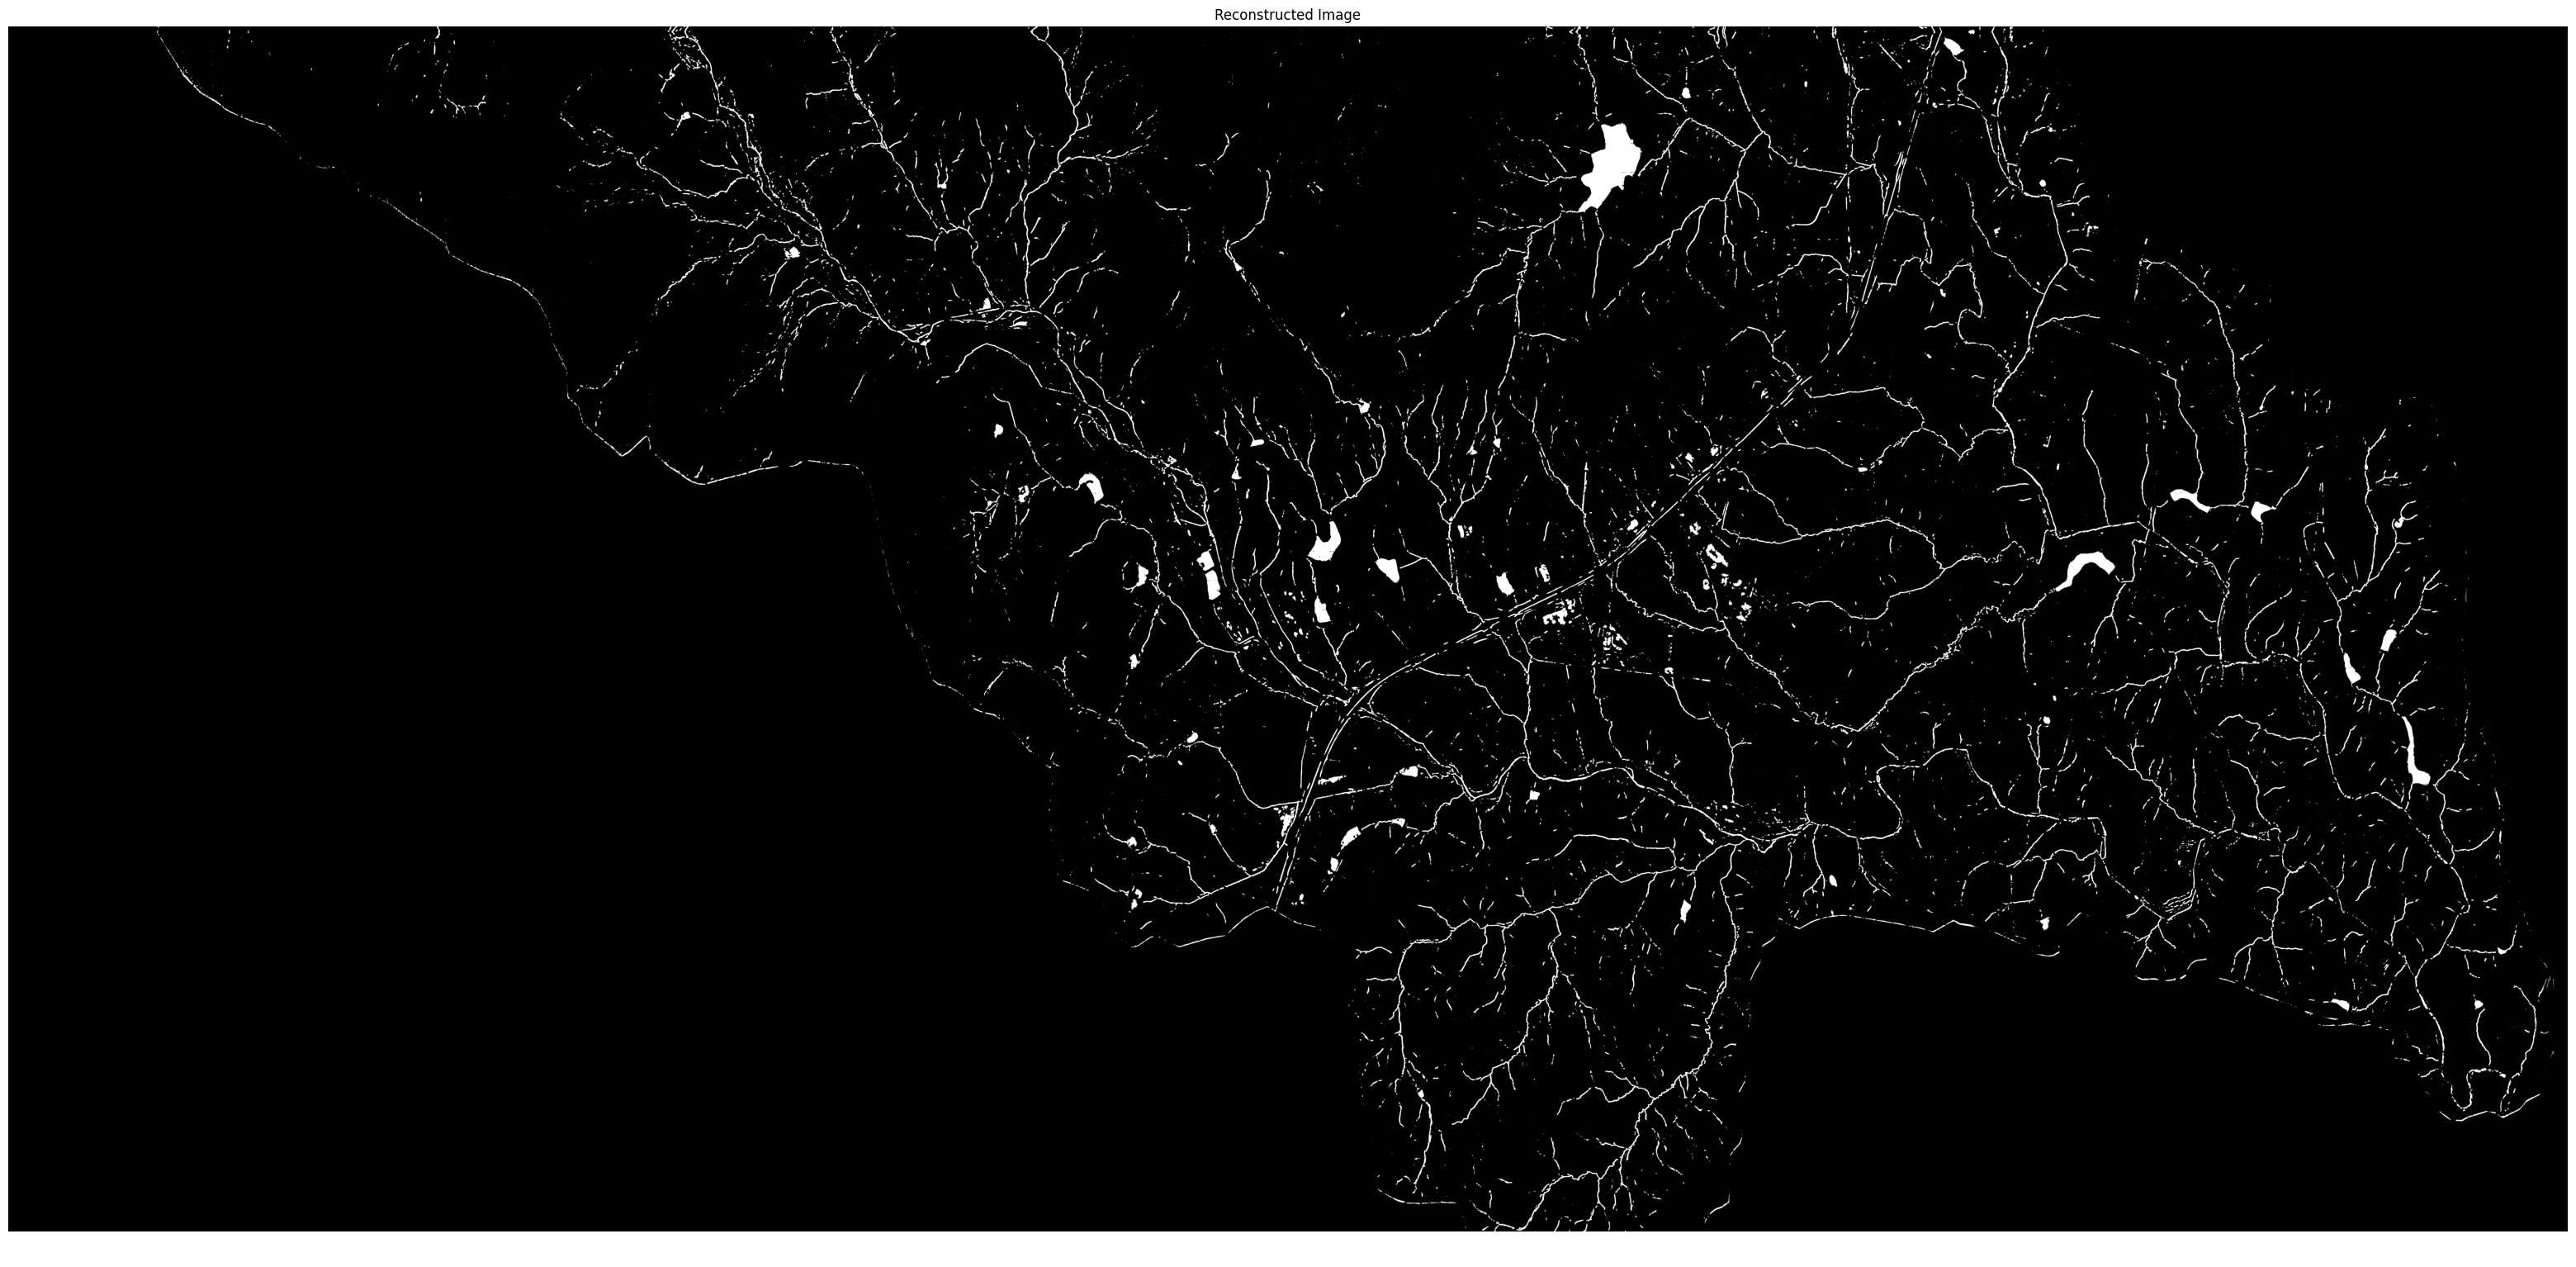

In [ ]:
# Step 1: define path the prediction results
npy_path = '/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/maml_1_500_1_20240430_013450_best_model.npy'

# Step 2: Determine the location
location = "covinton" # "rowancreek"  # Or "covinton"

# Step 3: Reconstruct and save image
reconstructed_image = load_and_reconstruct_patches(npy_path, location)
save_and_display_image(reconstructed_image, npy_path, display_only = True)  # Provide npy file path here


<ipython-input-1-9640f73c71b9>:70: RuntimeWarning: invalid value encountered in divide
  reconstructed /= count_matrix  # Avoid division by zero


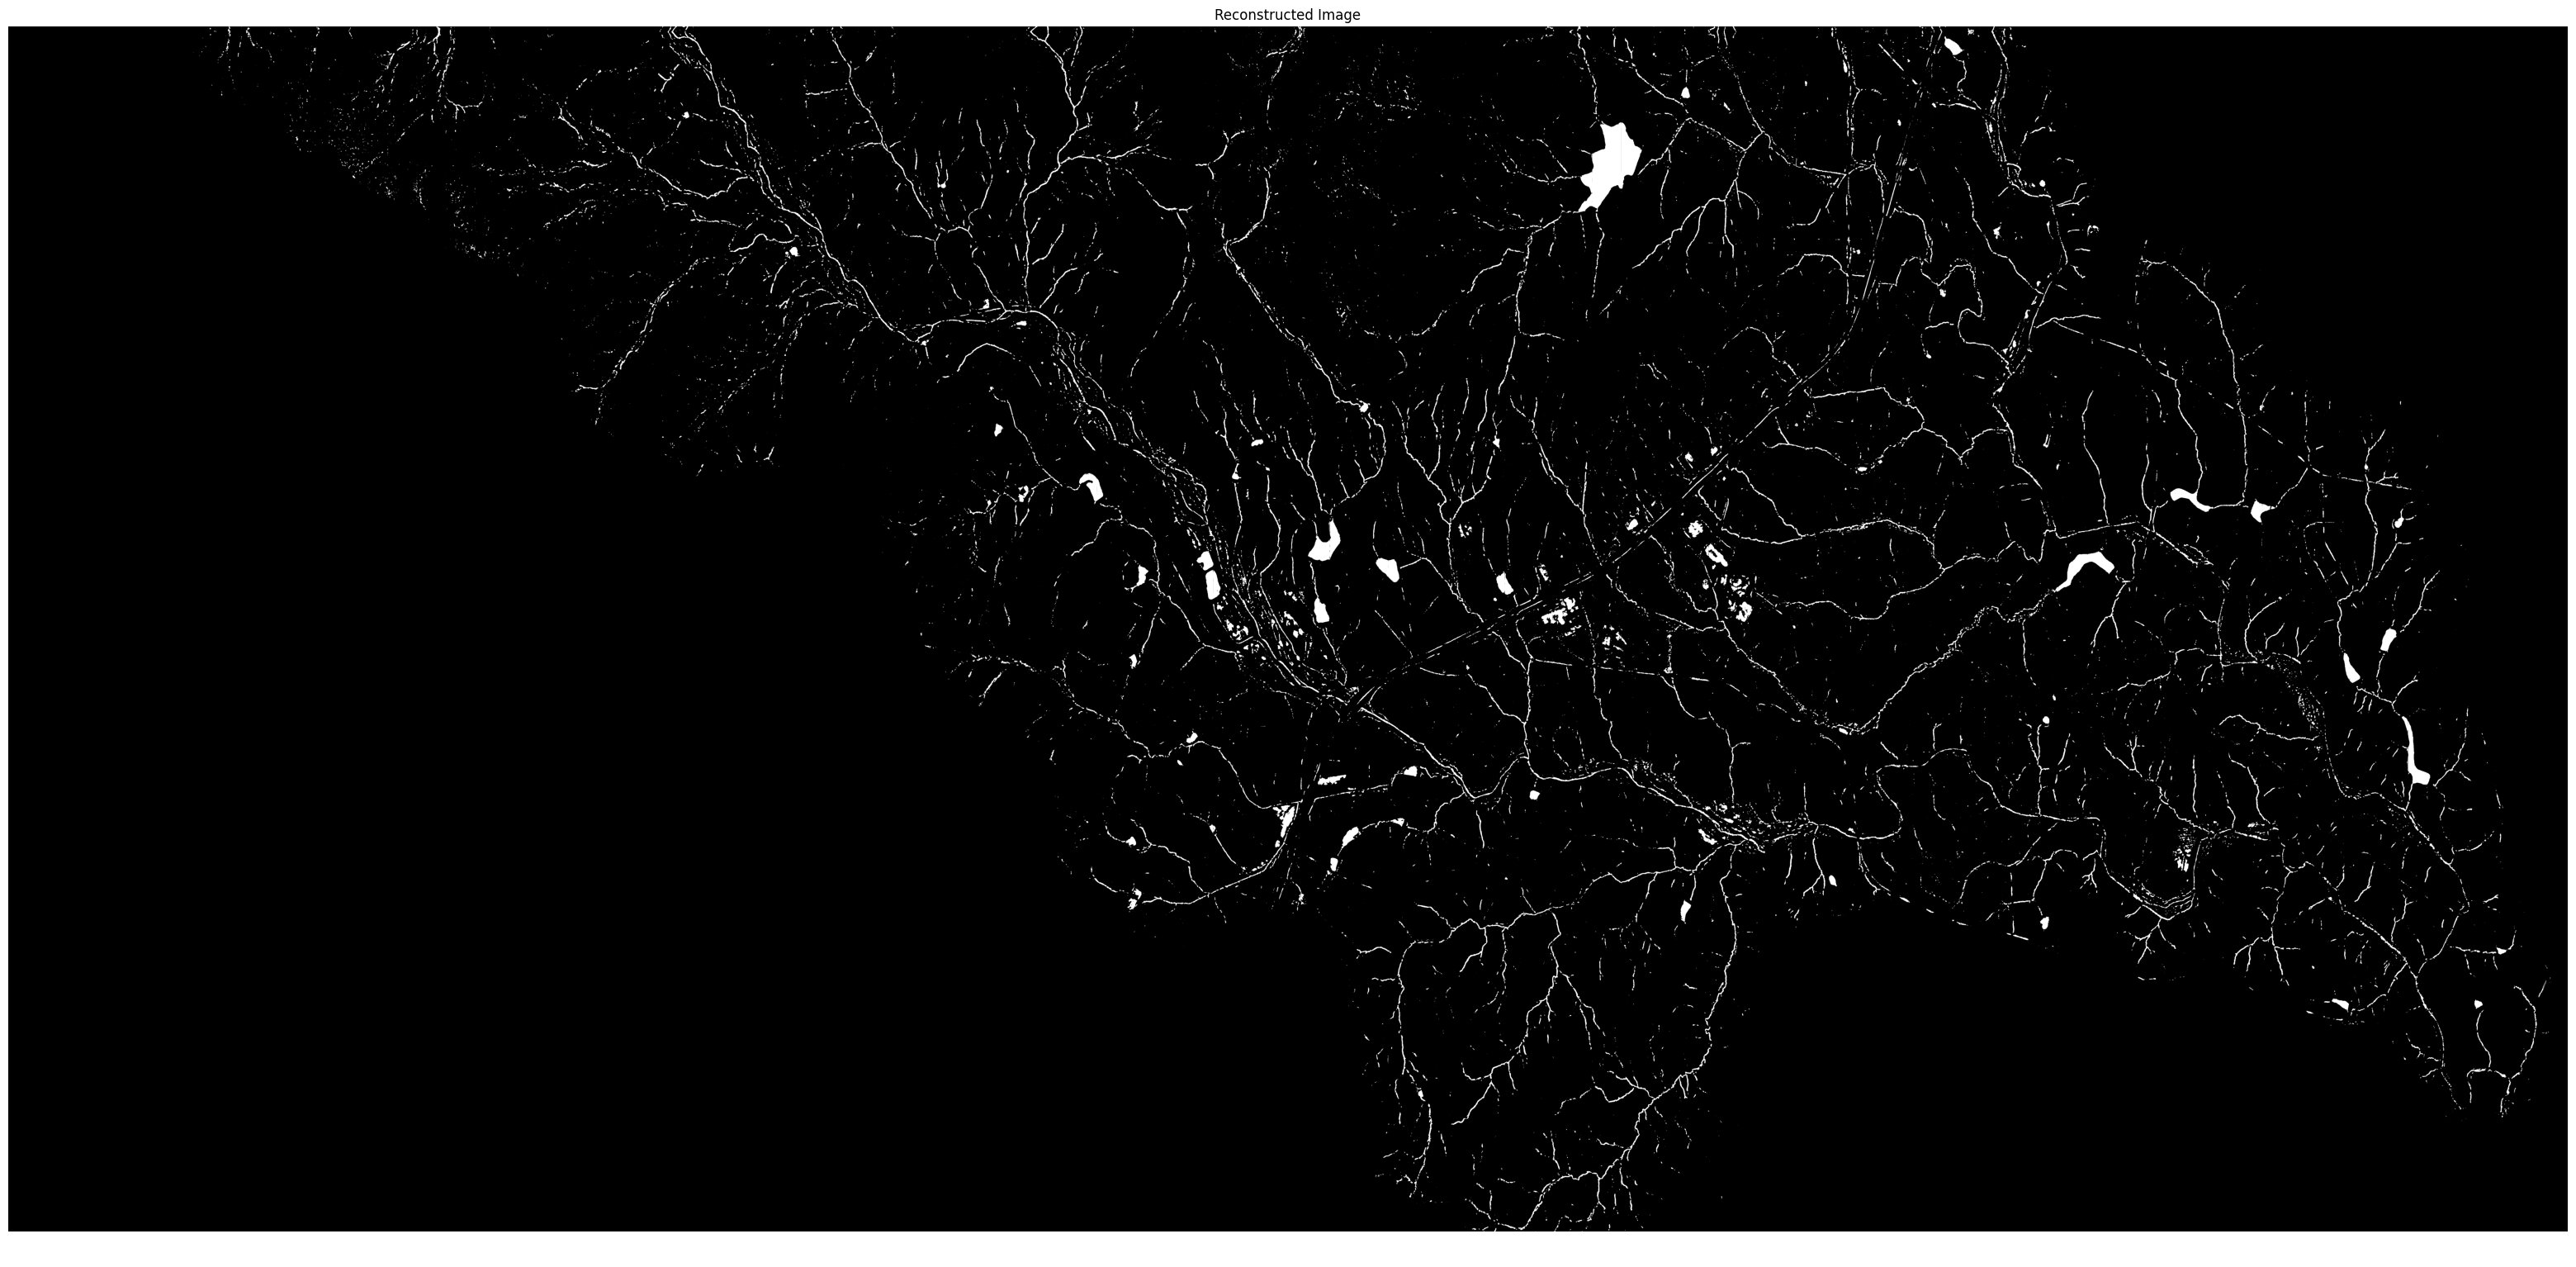

In [ ]:
# Step 1: define path the prediction results
npy_path = '/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/maml_1_500_1_20240503_201907_best_model.npy'

# Step 2: Determine the location
location = "covinton" # "rowancreek"  # Or "covinton"

# Step 3: Reconstruct and save image
reconstructed_image = load_and_reconstruct_patches(npy_path, location)
save_and_display_image(reconstructed_image, npy_path, display_only = True)  # Provide npy file path here


# Old version


## Reconstruction for Other than Covington

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Image.MAX_IMAGE_PIXELS = 933120000

def get_image_dimensions(file_path):
    # Open the image file using PIL
    with Image.open(file_path) as img:
        width, height = img.size  # img.size is a tuple (width, height)

    return width, height

def reconstruct_image(patches, out_dims, patch_size, overlap):
    width, height = out_dims
    stride = patch_size - overlap * 2  # Effective stride between patches

    # Initialize the output image and a count matrix for averaging overlaps
    reconstructed = np.zeros((height, width), dtype=np.float32)
    count_matrix = np.zeros((height, width), dtype=np.int32)

    num_patches_x = (width - overlap) // stride + 1
    num_patches_y = (height - overlap) // stride + 1
    print(num_patches_x, num_patches_y)

    idx = 0
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            if idx >= patches.shape[0]:
                break

            # Calculate the region where the patch should be added
            start_x = x * stride
            start_y = y * stride
            end_x = start_x + patch_size
            end_y = start_y + patch_size

            # Adjust the patch placement at the boundaries
            end_x = min(end_x, width)
            end_y = min(end_y, height)
            patch_width = end_x - start_x
            patch_height = end_y - start_y

            # Add patch to the reconstructed image
            reconstructed[start_y:end_y, start_x:end_x] += patches[idx][:patch_height, :patch_width].squeeze()
            count_matrix[start_y:end_y, start_x:end_x] += 1
            idx += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1
    reconstructed /= count_matrix

    return reconstructed

def visualize_and_save_image(image_array, file_name='reconstructed.tif'):
    # Convert the numpy array to an image for saving
    img = Image.fromarray(image_array.astype(np.uint8))  # Convert binary to 0-255 scale
    img.save(file_name)  # Save the image as a TIFF file

    # Display the image using matplotlib
    plt.figure(figsize=(25, 50))
    plt.imshow(image_array*255, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

## Covington Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from PIL import Image

def reconstruct_and_save_npy_files(patches):

  # Step 1: Load the numpy array from the .npy file
  data = patches
  print(data.shape)
  dim = data.shape
  buf = 30

  numr = 41
  numc = (dim[0]//41)-1
  count = -1
  for i in range(numr):
    # print("rows:", i)
    for j in range(int(numc)-1):
      # print("column:", j)
      count += 1
      temp = data[count][buf:-buf,buf:-buf]
      if j == 0:
        rows = temp
      else:
        rows = np.concatenate((rows,temp),axis = 1)

    # Concate the row ith to the total preditcion
    if i == 0:
      prediction_map = copy.copy(rows)
    else:
      prediction_map = np.concatenate((prediction_map,rows),axis = 0)


  #print("prediction_map",prediction_map.shape)
  prediction_map = prediction_map[:,:,0]
  print(prediction_map.shape)

  # Save the reconstructed image as tif with the same name
  output_path = "reconstructed.tif"
  print(f"Reconstructed image saved: {output_path}")
  image = Image.fromarray(prediction_map)
  image.save(output_path)

  # Step 7: Display the reconstructed image
  plt.figure(figsize=(40, 40))
  plt.imshow(prediction_map, cmap='gray')
  plt.axis('off')
  plt.show()

## Run this to visualize the prediction

(3654, 224, 224, 1)
(6724, 14268)
Reconstructed image saved: reconstructed.tif


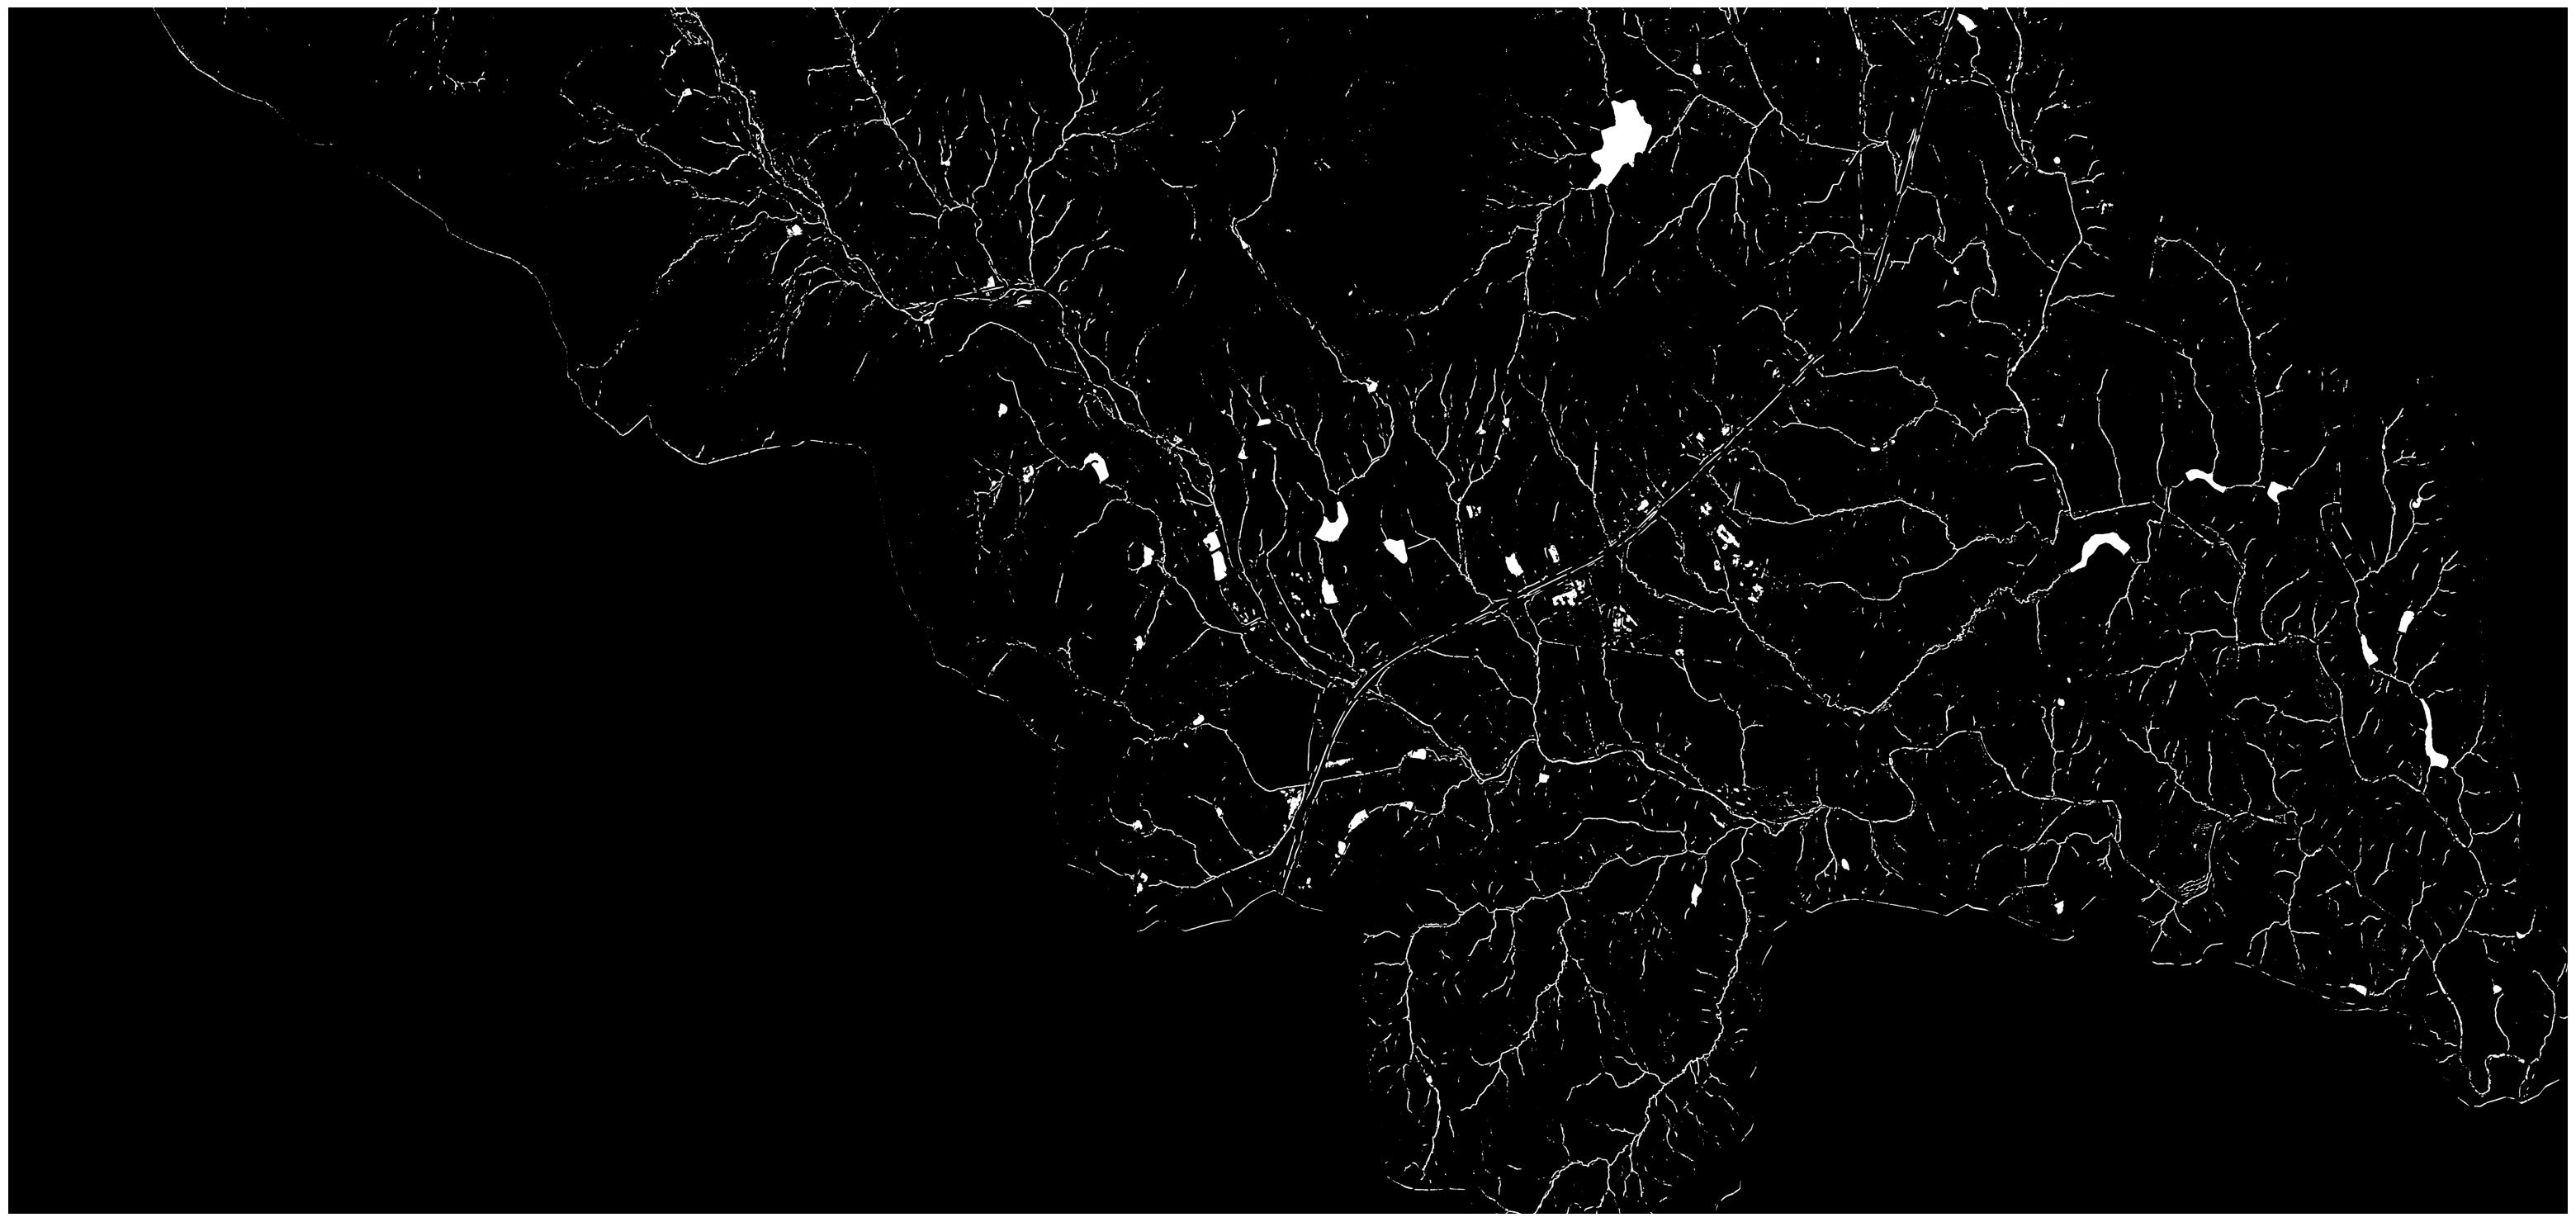

In [ ]:
# Example usage

location = "covinton"  # Replace with your location (rowancreek or covinton)
# npy_path = '/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/maml_1_500_1_20240429_220138_best_model_prediction_norm.npy'
npy_path = '/content/drive/MyDrive/Meta_learning_research/Notebooks/predicts/maml_1_500_1_20240430_013450_best_model.npy'

if location == "rowancreek":

  ref_path = "/content/drive/MyDrive/Meta_learning_research/Notebooks/TIFF/RowanCounty/reference_26102019.tif"  # Replace with the path to your TIF file

  width, height = get_image_dimensions(ref_path)
  patches = np.load(npy_path)
  output_size = (width, int(height/2))
  patch_size = 224
  overlap = 30

  reconstructed_image = reconstruct_image(patches, output_size, patch_size, overlap)

if location == "covinton":

  ref_path = "/content/drive/MyDrive/Meta_learning_research/Notebooks/TIFF/Covington/new_ref_w_nodata.tif"  # Replace with the path to your TIF file

  patches = np.load(npy_path)
  reconstruct_and_save_npy_files(patches)





# Patchifying test label

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the patches
test_label_patches = np.load("/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_label_patches.npy")
test_data_patches = np.load("/content/drive/MyDrive/Meta_learning_research/Notebooks/samples/Covington/bottom_half_test_data.npy")

# Check shapes to ensure they are loaded correctly
print(f"Test label patches shape: {test_label_patches.shape}")
print(f"Test data patches shape: {test_data_patches.shape}")

# Randomly select 25 sample indices
num_samples = 25
indices = random.sample(range(test_label_patches.shape[0]), num_samples)

# Plotting
fig, axes = plt.subplots(num_samples, 9, figsize=(20, num_samples * 2))

for idx, sample_idx in enumerate(indices):
    for channel in range(8):
        axes[idx, channel].imshow(test_data_patches[sample_idx, :, :, channel], cmap='gray')
        axes[idx, channel].axis('off')
        if idx == 0:
            axes[idx, channel].set_title(f"Channel {channel}")
    axes[idx, 8].imshow(test_label_patches[sample_idx], cmap='gray')
    axes[idx, 8].axis('off')
    if idx == 0:
        axes[idx, 8].set_title("Label")

plt.tight_layout()
plt.show()